# Deep Learning
## Practical Session 03
Görkem Saygili & Busra Ozgode Yigin, Department of Cognitive Science and Artificial Intelligence – Tilburg University




# Regularization

<div class="alert alert-block alert-info">
This Python Notebook is based on <a href=https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/3.5-classifying-movie-reviews.ipynb>https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/3.5-classifying-movie-reviews.ipynb</a> and <a href=https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/4.4-overfitting-and-underfitting.ipynb>https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/4.4-overfitting-and-underfitting.ipynb</a>.
</div>

Today, we will see strategies to prevent a model from overfitting, also known as regularization techniques. We will cover some of the most common ones:

* early stopping
* adjusting the size of the network
* weight regularization
* dropout

## Classifying movie reviews: the IMDB dataset

The example we will use to illustrate this is the "IMDB dataset", a set of 50,000 highly-polarized reviews from the Internet Movie Database. They are split into 25,000 
reviews for training and 25,000 reviews for testing, each set consisting in 50% negative and 50% positive reviews.

Just like the MNIST dataset, the IMDB dataset comes packaged with Keras. It has already been preprocessed: the reviews (sequences of words) have been turned into sequences of integers, where each integer stands for a specific word in a dictionary.

The following code will load the dataset:

In [25]:
from tensorflow.keras.datasets import imdb

# Remove some unwanted warnings
import logging
logging.getLogger('tensorflow').disabled = True 

nb_words = 2500
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=nb_words)
# Reducing the size of the dataset
train_data = train_data[:5000]
train_labels = train_labels[:5000]
test_data = test_data[:5000]
test_labels = test_labels[:5000]

The argument `num_words=2500` means that we will only keep the top 2,500 most frequently occurring words in the training data. Rare words will be discarded. This allows us to work with vector data of manageable size.

The variables `train_data` and `test_data` are lists of reviews, each review being a list of word indices (encoding a sequence of words). `train_labels` and `test_labels` are lists of 0s and 1s, where 0 stands for "negative" and 1 stands for "positive":

In [26]:
train_data[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 2,
 66,
 2,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 2,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 2,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 2,
 16,
 480,
 66,
 2,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 2,
 15,
 256,
 4,
 2,
 7,
 2,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 2,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 2,
 18,
 51,
 36,
 28,
 224,
 92,
 25

In [ ]:
train_labels[0]

1

Since we restricted ourselves to the top 2,500 most frequent words, no word index will exceed 2,499:

In [ ]:
max([max(sequence) for sequence in train_data])

2499

For kicks, here's how you can quickly decode one of these reviews back to English words:

In [27]:
# word_index is a dictionary mapping words to an integer index
word_index = imdb.get_word_index()
# We reverse it, mapping integer indices to words
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# We decode the review; note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

In [ ]:
decoded_review

"? this film was just brilliant casting location scenery story direction ? really ? the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same ? island as myself so i loved the fact there was a real connection with this film the witty ? throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly ? was amazing really ? at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little ? that played the ? of ? and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big ? for the whole film but these children are amazing and should be ? for what they have done don't you think the whole story was so lovely because it was true and 

### Exercise 1 - Preparing the data


We cannot feed lists of integers into a neural network. We have to turn our lists into tensors. There are two ways we could do that:

* We could pad our lists so that they all have the same length, and turn them into an integer tensor of shape `(samples, word_indices)`, then use as first layer in our network a layer capable of handling such integer tensors (e.g the `Embedding` layer).
* We could one-hot-encode our lists to turn them into vectors of 0s and 1s. Concretely, this would mean for instance turning the sequence `[3, 5]` into a 2,500-dimensional vector that would be all-zeros except for indices 3 and 5, which would be ones. This is similar to the one-hot encodings we already used as targets in the multi-class classification task, except that here, several positions can hold a one at the same time. Then we could use as first layer in our network a `Dense` layer, capable of handling floating point vector data.

We will go with the latter solution. Let's vectorize our data, which we will do manually for maximum clarity:

In [28]:
import numpy as np

def vectorize_sequences(sequences, dimension=nb_words):
    ''' Returns a vector of zeros, except for indices corresponding to the words 
    in sequence that are set to one '''
    ### PUT YOUR CODE HERE ###
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results
    ### END ###

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)

Here's what our samples look like now:

In [29]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

We should also vectorize our labels, which is straightforward:

In [30]:
# Our vectorized labels
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')
y_train[0]

1.0

Now our data is ready to be fed into a neural network.

### Exercise 2 - Building our network


Our input data is simply vectors, and our labels are scalars (1s and 0s): a type of network that performs well on such a problem would be a simple stack of fully-connected layers. By now, you should be able to implement the model by yourself. As we are going to instantiate several models, wrap the code in a function that takes the number of units as a parameter. The neural network should have two hidden layers with `relu` activations. Don't forget to compile the model.

In [31]:
from tensorflow.keras import models
from tensorflow.keras import layers

def build_model(nb_units=16):
    ### PUT YOUR CODE HERE ###
    model = models.Sequential()
    model.add(layers.Dense(nb_units, activation='relu', input_shape=(nb_words,)))
    model.add(layers.Dense(nb_units, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model
    ### END ###

### Exercise 3 - Validating our approach

We will create a validation set by setting apart 1,000 samples from the original training data:

In [32]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = y_train[:1000]
partial_y_train = y_train[1000:]

We will now train our model for 20 epochs, in mini-batches of 128 samples. At the same time we will monitor loss and accuracy on the 1,000 samples that we set apart.

In [33]:
model = build_model()
original_hist = model.fit(partial_x_train,
                          partial_y_train,
                          epochs=20,
                          batch_size=128,
                          validation_data=(x_val, y_val),
                          verbose=0)

Remember that to call the `model.fit()` returns a `History` object. This object has a member `history`, which is a dictionary containing data about everything that happened during training. Let's take a look at it:

In [34]:
history_dict = original_hist.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In our case, it contains 4 entries: one for the loss + one per metric that was being monitored, for both training and validation sets. Let's plot the training and validation loss toghether, as well as the training and validation accuracy (on a second plot). For this, you can use the utility function `plot_history()` defined in `plot_history.py` (don't forget to upload the file if you are working on the server).

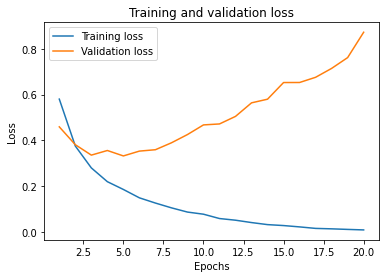

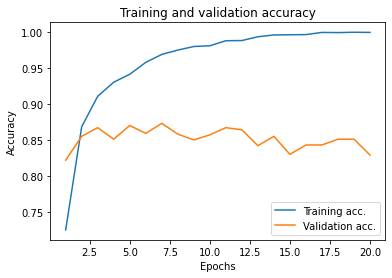

In [36]:
%matplotlib inline

import sys    
path_to_module = '/content/drive/MyDrive/Deep_Learning_Spring23/Practical 3/'
sys.path.append(path_to_module)

from plot_history import plot_history

### PUT YOUR CODE HERE ###
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

plot_history(data_list=[loss, val_loss],
             label_list=['Training loss', 'Validation loss'],
             title='Training and validation loss',
             ylabel='Loss')
plot_history(data_list=[acc, val_acc],
             label_list=['Training acc.', 'Validation acc.'],
             title='Training and validation accuracy',
             ylabel='Accuracy')
### END ###

The blue lines are the training loss and accuracy, while the orange ones are the validation loss and accuracy.

As you can see, the training loss decreases with every epoch and the training accuracy increases with every epoch. That's what you would expect when running gradient descent optimization -- the quantity you are trying to minimize should get lower with every iteration. But that isn't the case for the validation loss and accuracy: they seem to peak at the fourth epoch. That is why a validation set is so important: a model that performs better on the training data isn't necessarily a model that will do better on data it has never seen before. In precise terms, what you are seeing is "overfitting": after the fourth epoch, we are over-optimizing on the training data, and we ended up learning representations that are specific to the training data and do not generalize to data outside of the training set.

While we can simply prevent overfitting with early stopping, i.e. by stoping training after four epochs (as we will do in a first attempt), there is a range of more advanced techniques you can leverage to mitigate overfitting. We will cover some of them in the rest of this tutorial.

But for now, let's train a new network from scratch for four epochs, then evaluate it on our test data:

In [ ]:
model = build_model()
model.fit(x_train, y_train, epochs=4, batch_size=128, verbose=0)
results = model.evaluate(x_test, y_test)

157/157 [==============================] - 0s 2ms/step - loss: 0.3691 - accuracy: 0.8380


In [ ]:
results

[0.3691403567790985, 0.8379999995231628]

Our fairly naive approach achieves an accuracy of ~84%.

## Fighting overfitting

In the example we just explored, as well as other examples we have seeen in the past weeks (e.g.the Boston house price regression problem), we could notice that the performance of our model on the held-out validation data would always peak after a few epochs and would then start degrading. Said otherwise, our model would quickly start to _overfit_ to the training data. Overfitting happens in every single machine learning problem. Learning how to deal with overfitting is essential to mastering machine learning.

The fundamental issue in machine learning is the tension between optimization and generalization. "Optimization" refers to the process of adjusting a model to get the best performance possible on the training data (the "learning" in "machine learning"), while "generalization" refers to how well the trained model would perform on data it has never seen before. The goal of the game is to get good generalization, of course, but you do not control generalization directly; you can only adjust the model based on its training data.

At the beginning of training, optimization and generalization are correlated: the lower your loss on training data, the lower your loss on test data. While this is happening, your model is said to be _under-fit_ : there is still progress to be made; the network hasn't yet modeled all relevant patterns in the training data. But after a certain number of iterations on the training data, generalization stops improving, validation metrics stall, then start degrading: the model is then starting to over-fit, i.e. is it starting to learn patterns that are specific to the training data but that are misleading or irrelevant when it comes to new data.

To prevent a model from learning misleading or irrelevant patterns found in the training data, _the best solution is of course to get more training data_. A model trained on more data will naturally generalize better. When that is no longer possible, the next best solution is to modulate the quantity of information that your model is allowed to store, or to add constraints on what information it is allowed to store. If a network can only afford to memorize a small number of patterns, the optimization process will force it to focus on the most prominent patterns, which have a better chance of generalizing well.

The process of fighting overfitting in this way is called _regularization_. Let's review some of the most common regularization techniques, and let's apply them in practice to improve our movie classification model.

### Exercise 4 - Reducing the network's size


The simplest way to prevent overfitting is to reduce the size of the model, i.e. the number of learnable parameters in the model (which is determined by the number of layers and the number of units per layer). In deep learning, the number of learnable parameters in a model is often referred to as the model's "capacity". Intuitively, a model with more parameters will have more "memorization capacity" and therefore will be able to easily learn a perfect dictionary-like mapping between training samples and their targets, a mapping without any generalization power. Always keep this in mind: deep learning models tend to be good at fitting the training data, but the real challenge is generalization, not fitting.

On the other hand, if the network has limited memorization resources, it will not be able to learn this mapping as easily, and thus, in order to minimize its loss, it will have to resort to learning compressed representations that have predictive power regarding the targets -- precisely the type of representations that we are interested in. At the same time, keep in mind that you should be using models that have enough parameters that they won't be underfitting: your model shouldn't be starved for memorization resources. There is a compromise to be found between "too much capacity" and "not enough capacity".

Unfortunately, there is no magical formula to determine what the right number of layers is, or what the right size for each layer is. You will have to evaluate an array of different architectures (on your validation set, not on your test set, of course) in order to find the right model size for your data. The general workflow to find an appropriate model size is to start with relatively few layers and parameters, and start increasing the size of the layers or adding new layers until you see diminishing returns with regard to the validation loss.

Let's try this on our movie review classification network. Our original network, a two hidden layer network with 16 units per hidden layer, was able to reach ~84% of accuracy. Let's try replacing it with a smaller network that has only 4 units per hidden layer. Let's also add to this benchmark a network that has much more capacity, far more than the problem would warrant: 256 units per hidden layer. Create and train the two models, then plot the validation loss of the three architectures.

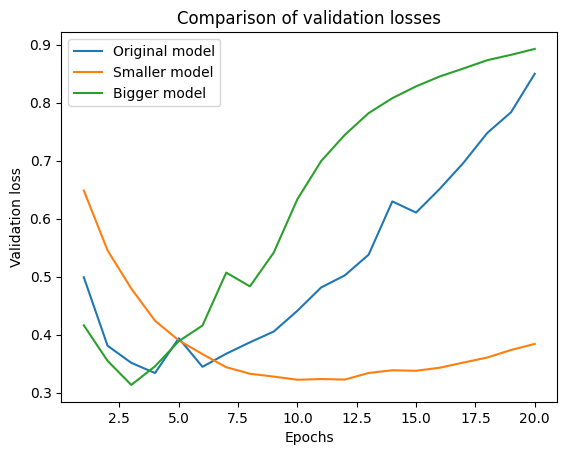

In [ ]:
### PUT YOUR CODE HERE ###
smaller_model = build_model(nb_units=4)
smaller_model_hist = smaller_model.fit(partial_x_train, partial_y_train,
                                       epochs=20,
                                       batch_size=128,
                                       validation_data=(x_val, y_val),
                                       verbose=0)
bigger_model = build_model(nb_units=256)
bigger_model_hist = bigger_model.fit(partial_x_train, partial_y_train,
                                     epochs=20,
                                     batch_size=128,
                                     validation_data=(x_val, y_val),
                                     verbose=0)
original_val_loss = original_hist.history['val_loss']
smaller_model_val_loss = smaller_model_hist.history['val_loss']
bigger_model_val_loss = bigger_model_hist.history['val_loss']
plot_history(data_list=[original_val_loss, smaller_model_val_loss, bigger_model_val_loss],
             label_list=['Original model', 'Smaller model', 'Bigger model'],
             title='Comparison of validation losses',
             ylabel='Validation loss')
### END ###


As you can see, the smaller network starts overfitting later than the reference one (after 10/11 epochs rather than 4) and its performance degrades much more slowly once it starts overfitting. The bigger network, on the other hand starts overfitting earlier, and overfits much more severely. Its validation loss also tends to be more noisy.

Meanwhile, here are the training losses for our three networks:

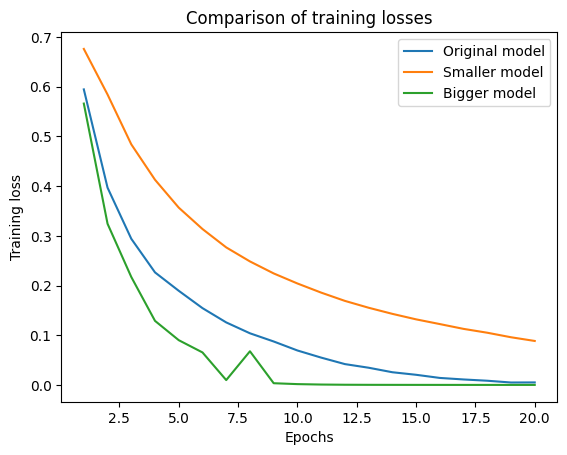

In [ ]:
### PUT YOUR CODE HERE ###
original_train_loss = original_hist.history['loss']
smaller_model_train_loss = smaller_model_hist.history['loss']
bigger_model_train_loss = bigger_model_hist.history['loss']

plot_history(data_list=[original_train_loss, smaller_model_train_loss, bigger_model_train_loss],
             label_list=['Original model', 'Smaller model', 'Bigger model'],
             title='Comparison of training losses',
             ylabel='Training loss')
### END ###

As you can see, the bigger network gets its training loss near zero very quickly. The more capacity the network has, the quicker it will be 
able to model the training data (resulting in a low training loss), but the more susceptible it is to overfitting (resulting in a large 
difference between the training and validation loss).

### Exercise 5 - Adding weight regularization


You may be familiar with _Occam's Razor_ principle: given two explanations for something, the explanation most likely to be correct is the 
"simplest" one, the one that makes the least amount of assumptions. This also applies to the models learned by neural networks: given some 
training data and a network architecture, there are multiple sets of weights values (multiple _models_ ) that could explain the data, and 
simpler models are less likely to overfit than complex ones.

A "simple model" in this context is a model where the distribution of parameter values has less entropy (or a model with fewer 
parameters altogether, as we saw in the section above). Thus a common way to mitigate overfitting is to put constraints on the complexity 
of a network by forcing its weights to only take small values, which makes the distribution of weight values more "regular". This is called 
"weight regularization", and it is done by adding to the loss function of the network a _cost_ associated with having large weights. This 
cost comes in two flavors:

* L1 regularization, where the cost added is proportional to the _absolute value of the weights coefficients_ (i.e. to what is called the 
"L1 norm" of the weights).
* L2 regularization, where the cost added is proportional to the _square of the value of the weights coefficients_ (i.e. to what is called 
the "L2 norm" of the weights). L2 regularization is also called _weight decay_ in the context of neural networks. Don't let the different 
name confuse you: weight decay is mathematically the exact same as L2 regularization.

In Keras, weight regularization is added by passing _weight regularizer instances_ to layers as keyword arguments (https://keras.io/regularizers). Let's add regularization as a new parameter of the network building function:

In [ ]:
from tensorflow.keras import regularizers

def build_regularized_model(nb_units=16, regularizer=regularizers.l2(0.001)):
    ### PUT YOUR CODE HERE ###
    model = models.Sequential()
    model.add(layers.Dense(nb_units, kernel_regularizer=regularizer,
                           activation='relu', input_shape=(nb_words,)))
    model.add(layers.Dense(nb_units, kernel_regularizer=regularizer,
                           activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model
    ### END ###

`l2(0.001)` means that every coefficient in the weight matrix of the layer will add `0.001 * weight_coefficient_value` to the total loss of 
the network.

Here's the impact of our L2 regularization penalty:

In [ ]:
l2_model = build_regularized_model()
l2_model_hist = l2_model.fit(partial_x_train, partial_y_train,
                             epochs=20,
                             batch_size=128,
                             validation_data=(x_val, y_val),
                             verbose=0)

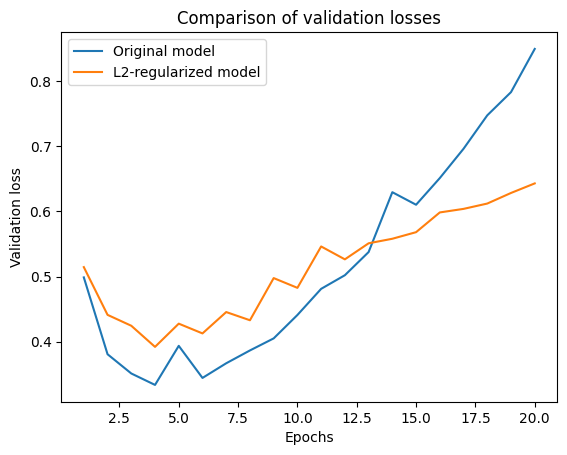

In [ ]:
l2_model_val_loss = l2_model_hist.history['val_loss']

plot_history(data_list=[original_val_loss, l2_model_val_loss],
             label_list=['Original model', 'L2-regularized model'],
             title='Comparison of validation losses',
             ylabel='Validation loss')

As you can see, the model with L2 regularization has become much more resistant to overfitting than the reference model (crosses), even though both models have the same number of parameters.

As alternatives to L2 regularization, you could use one of the following Keras weight regularizers:

In [ ]:
from tensorflow.keras import regularizers

# L1 regularization
regularizers.l1(0.001)

# L1 and L2 regularization at the same time
regularizers.l1_l2(l1=0.001, l2=0.001)

#### Developing new regularizers

Any function that takes in a weight matrix and returns a loss contribution tensor can be used as a regularizer. As an exercise, we will reimplement the L2 regularizer by ourselves. As a reminder, here is it's definition:

<br>
<center>
$ L2(W) = \lambda \sum\limits_{w\in W} w^2, $
</center>

where $W$ is the matrix of weights to regularize and $\lambda$ is the coefficient that regulates the contribution of the regularization term to the final loss.

Reimplement the L2 loss function using keras operations `K.sum()` and `K.square()`. Then check that you get similar results to those we obtained with keras loss function. 

In [ ]:
from tensorflow.keras import backend as K


def l2_reg(weight_matrix, lmbd):
    ### PUT YOUR CODE HERE ###
    return lmbd * K.sum(K.square(weight_matrix))
    ### END ###
    
l2_custom_model = build_regularized_model(regularizer=(lambda w: l2_reg(w, 0.001)))
l2_custom_model_hist = l2_custom_model.fit(partial_x_train, partial_y_train,
                                           epochs=20,
                                           batch_size=128,
                                           validation_data=(x_val, y_val),
                                           verbose=0)

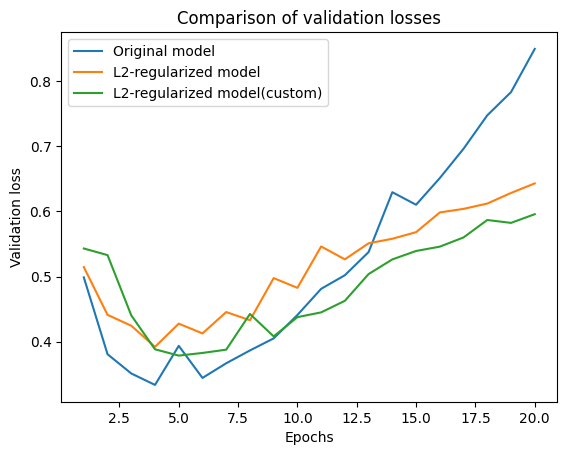

In [ ]:
l2_custom_model_val_loss = l2_custom_model_hist.history['val_loss']

plot_history(data_list=[original_val_loss, l2_model_val_loss, l2_custom_model_val_loss],
             label_list=['Original model', 'L2-regularized model', 'L2-regularized model(custom)'],
             title='Comparison of validation losses',
             ylabel='Validation loss')

### Exercise 6 - Adding dropout


Dropout is one of the most effective and most commonly used regularization techniques for neural networks, developed by Hinton and his students at the University of Toronto. Dropout, applied to a layer, consists of randomly "dropping out" (i.e. setting to zero) a number of output features of the layer during training. Let's say a given layer would normally have returned a vector `[0.2, 0.5, 1.3, 0.8, 1.1]` for a given input sample during training; after applying dropout, this vector will have a few zero entries distributed at random, e.g. `[0, 0.5, 1.3, 0, 1.1]`. The "dropout rate" is the fraction of the features that are being zeroed-out; it is usually set between 0.2 and 0.5. At test time, no units are dropped out, and instead the layer's output values are scaled down by a factor equal to the dropout rate, so as to 
balance for the fact that more units are active than at training time.

Consider a Numpy matrix containing the output of a layer, `layer_output`, of shape `(batch_size, features)`. At training time, we would be zero-ing out at random a fraction of the values in the matrix:

``` python
# At training time: we drop out 50% of the units in the output
layer_output *= np.randint(0, high=2, size=layer_output.shape)
```

At test time, we would be scaling the output down by the dropout rate. Here we scale by 0.5 (because we were previous dropping half the 
units):

``` python
# At test time:
layer_output *= 0.5
```


Note that this process can be implemented by doing both operations at training time and leaving the output unchanged at test time, which is 
often the way it is implemented in practice:

``` python
# At training time:
layer_output *= np.randint(0, high=2, size=layer_output.shape)
# Note that we are scaling *up* rather scaling *down* in this case
layer_output /= 0.5
```


This technique may seem strange and arbitrary. Why would this help reduce overfitting? Geoff Hinton has said that he was inspired, among 
other things, by a fraud prevention mechanism used by banks -- in his own words: _"I went to my bank. The tellers kept changing and I asked 
one of them why. He said he didn’t know but they got moved around a lot. I figured it must be because it would require cooperation 
between employees to successfully defraud the bank. This made me realize that randomly removing a different subset of neurons on each 
example would prevent conspiracies and thus reduce overfitting"_.

The core idea is that introducing noise in the output values of a layer can break up happenstance patterns that are not significant (what 
Hinton refers to as "conspiracies"), which the network would start memorizing if no noise was present. 

In Keras you can introduce dropout in a network via the `Dropout` layer, which gets applied to the output of layer right before it, e.g.:

In [ ]:
model.add(layers.Dropout(0.4))

Let's modify the definition of our network building function to add two `Dropout` layers (after each hidden layer).</span>

In [ ]:
def build_dropout_model(nb_units=16, dropout_rate=0.4):
    ### PUT YOUR CODE HERE ###
    model = models.Sequential()
    model.add(layers.Dense(nb_units, activation='relu', input_shape=(nb_words,)))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(nb_units, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model
    ### END ###

In [ ]:
dpt_model = build_dropout_model()
dpt_model_hist = dpt_model.fit(partial_x_train, partial_y_train,
                               epochs=20,
                               batch_size=128,
                               validation_data=(x_val, y_val),
                               verbose=0)

Let's plot the results:

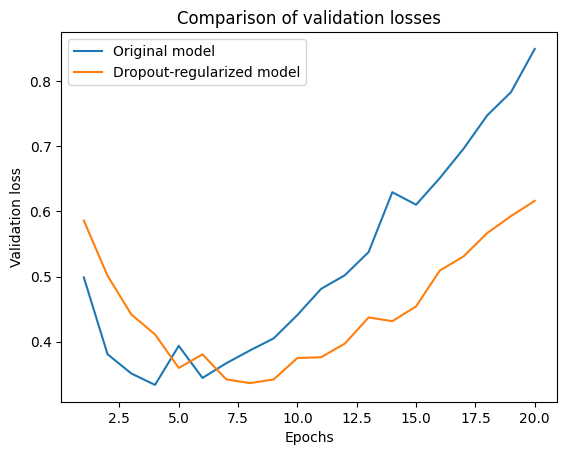

In [ ]:
dpt_model_val_loss = dpt_model_hist.history['val_loss']

plot_history(data_list=[original_val_loss, dpt_model_val_loss],
             label_list=['Original model', 'Dropout-regularized model'],
             title='Comparison of validation losses',
             ylabel='Validation loss')

Again, a clear improvement over the reference network.

## Further experiments

You can try combining the different techniques we have seen today, or optimizing the hyperparameters (such as lambda or the dropout rate) to improve on the 84% of accuracy we got with the original model. How far can you get?

## Conclusions


Here's what you should take away from today:

* There's usually quite a bit of preprocessing you need to do on your raw data in order to be able to feed it -- as tensors -- into a neural network. In the case of sequences of words, they can be encoded as binary vectors -- but there are other (better) encoding options too. 
* As they get better on their training data, neural networks eventually start _overfitting_ and end up obtaining increasingly worse results on data never-seen-before. Make sure to always monitor performance on data that is outside of the training set.
* The most common ways to prevent overfitting in neural networks are:
  * Getting more training data.
  * Reducing the capacity of the network.
  * Early stopping
  * Adding weight regularization.
  * Adding dropout.